# LeNet PyTorch with CIFAR10
- **Task**: Classification
- **Data**: CIFAR10 Dataset
- **Model**: LeNet
- **Loss function**: Cross Entropy Loss
- **Optimization**: Adam

In [1]:
!pip install -q watermark

In [2]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

torch: 2.1.2



## 1. Import Library

In [3]:
!pip install -q torchsummary

In [4]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Data

### 2.1. CIFAR10 Dataset

#### 2.1.1. Load dataset to compute Mean and Std to Normalize Z-score

In [5]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10(root='data', train=True, transform=compute_transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=2)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

100%|██████████| 170498071/170498071 [00:02<00:00, 66606349.93it/s]


Extracting data/cifar-10-python.tar.gz to data
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2823, 0.2783, 0.2990])


#### 2.1.2. Load CIFAR10 Dataset

In [6]:
batch_size = 64
# Load CIFAR10 dataset
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2823, 0.2783, 0.2990))])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 2.2. Data Information

In [7]:
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Number of training samples: 50000
Number of testing samples: 10000


In [8]:
print(f"Datatype of the 1st training sample: {trainset[0][0].type()}")
print(f"Size of the 1st training sample: {testset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([3, 224, 224])


### 2.3. Data Visualization

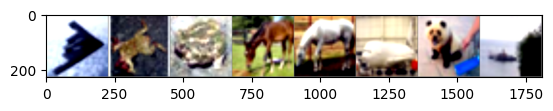

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

## 3. Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, imdim=3, num_classes=10):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(imdim, 64, kernel_size=5, stride=3, padding=0)
        self.mp = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=3, padding=0)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128*5*5, 1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1024)
        self.relu4 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        in_size = x.size(0)
        out1 = self.mp(self.relu1(self.conv1(x)))
        out2 = self.mp(self.relu2(self.conv2(out1)))
        out2 = out2.view(in_size, -1)
        out3 = self.relu3(self.fc1(out2))
        out = self.relu4(self.fc2(out3))

        return self.fc3(out)

In [11]:
model = LeNet(num_classes=10).to(device)

In [12]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 74, 74]           4,864
              ReLU-2           [-1, 64, 74, 74]               0
         MaxPool2d-3           [-1, 64, 37, 37]               0
            Conv2d-4          [-1, 128, 11, 11]         204,928
              ReLU-5          [-1, 128, 11, 11]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Linear-7                 [-1, 1024]       3,277,824
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 4,547,466
Trainable params: 4,547,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

In [13]:
# Generating a random tensor
input_tensor = torch.rand(1, 3, 224, 224).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([1, 10])


## 4. Loss Function and Optimization

In [14]:
LR = 1e-3
EPOCHS = 150

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

## 5. Train

### 5.1. Evaluation Function

In [16]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [17]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'Test_loss: {test_loss}')
print(f'Test_accuracy: {test_accuracy}')

Test_loss: 2.303963284583608
Test_accuracy: 10.71


In [18]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [19]:
# train
for epoch in range(EPOCHS):
    start_time = time.time()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Time: {time.time() - start_time:.3f}s")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 1.4984, Accuracy: 45.55%, Test Loss: 1.2674, Test Accuracy: 54.13%, Time: 61.195s
Epoch [2/150], Loss: 1.1764, Accuracy: 58.23%, Test Loss: 1.1397, Test Accuracy: 58.92%, Time: 62.084s
Epoch [3/150], Loss: 1.0210, Accuracy: 63.65%, Test Loss: 1.0339, Test Accuracy: 63.65%, Time: 61.957s
Epoch [4/150], Loss: 0.8925, Accuracy: 68.46%, Test Loss: 1.0285, Test Accuracy: 64.64%, Time: 62.572s
Epoch [5/150], Loss: 0.7712, Accuracy: 72.67%, Test Loss: 1.0028, Test Accuracy: 65.55%, Time: 61.866s
Epoch [6/150], Loss: 0.6566, Accuracy: 76.71%, Test Loss: 1.1058, Test Accuracy: 65.14%, Time: 61.479s
Epoch [7/150], Loss: 0.5455, Accuracy: 80.65%, Test Loss: 1.1171, Test Accuracy: 66.24%, Time: 61.645s
Epoch [8/150], Loss: 0.4427, Accuracy: 83.96%, Test Loss: 1.2306, Test Accuracy: 65.94%, Time: 61.866s
Epoch [9/150], Loss: 0.3447, Accuracy: 87.73%, Test Loss: 1.4951, Test Accuracy: 64.18%, Time: 62.033s
Epoch [10/150], Loss: 0.2852, Accuracy: 89.95%, Test Loss: 1.6815, Test A

## 6. Inference

### 6.1. Loss Visualization

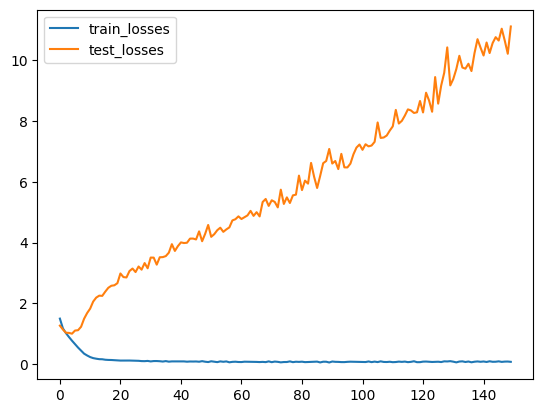

In [20]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

### 6.2. Accuracy Visualization

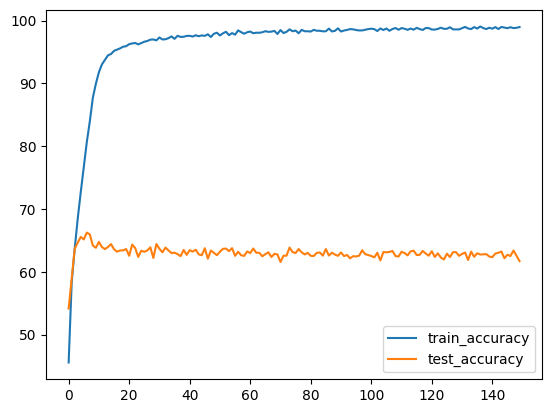

In [21]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

### 6.3. Best Accuracy

In [22]:
# the best accuracy
best_epoch_test = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch_test + 1} with test accuracy: {test_accuracies[best_epoch_test]:.2f}%")
best_epoch_train = np.argmax(train_accuracies)
print(f"\nBest epoch: {best_epoch_train + 1} with train accuracy: {train_accuracies[best_epoch_train]:.2f}%")


Best epoch: 7 with test accuracy: 66.24%

Best epoch: 137 with train accuracy: 99.07%


## 7. Conclusion
- **Train Accuracy**: 99.07%
- **Test Accuracy**: 66.24%